In [ ]:
from pymatgen.core import Structure
import numpy as np
import os

# 1. LLZO CIF 데이터 로드 
cif_string = open("./etz.cif", "r").read()
structure = Structure.from_str(cif_string, fmt="cif")


# 슈퍼셀의 크키가 결과에 영향을 미치는지 확인. Convergence Test 필요
N = 2
# 2. 슈퍼셀 생성 (단위 셀은 너무 작으므로 확장이 필수)
structure.make_supercell([N, N, N])

# 3. 초기 상태(Configuration) 배열 생성
initial_sites = [] # [(x,y,z, 'occupied'), ...]

for site in structure:
    species = site.species
    coords = site.frac_coords
    
    # 리튬 자리인 경우만 처리
    if "Li" in [s.symbol for s in species.elements]:
        # 부분 점유율(Occupancy) 확인
        # 예: Li0.374 -> 확률적으로 1(Li) 또는 0(Vacancy) 결정
        prob_li = species.get("Li", 0) # 0.374
        
        if np.random.rand() < prob_li:
            state = 1 # Li 있음
        else:
            state = 0 # Vacancy
            
        initial_sites.append({
            "coords": coords,
            "state": state,
            "site_name": site.label
        })

print(f"초기화 완료: 총 {len(initial_sites)}개의 리튬 사이트 생성됨.")



Structure Summary
Lattice
    abc : 12.9751 12.9751 12.9751
 angles : 90.0 90.0 90.0
 volume : 2184.3998649517507
      A : np.float64(12.9751) np.float64(0.0) np.float64(7.944957341808411e-16)
      B : np.float64(2.0865552191819325e-15) np.float64(12.9751) np.float64(7.944957341808411e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(12.9751)
    pbc : True True True
PeriodicSite: Li0 (Li:0.28) (0.9805, 2.164, 10.77) [0.07557, 0.1668, 0.8297]
PeriodicSite: Li0 (Li:0.28) (11.99, 10.81, 2.209) [0.9244, 0.8332, 0.1703]
PeriodicSite: Li0 (Li:0.28) (1.08, 10.71, 1.035) [0.08323, 0.8256, 0.07974]
PeriodicSite: Li0 (Li:0.28) (5.408, 8.751, 5.453) [0.4168, 0.6744, 0.4203]
PeriodicSite: Li0 (Li:0.28) (5.507, 10.81, 4.278) [0.4244, 0.8332, 0.3297]
PeriodicSite: Li0 (Li:0.28) (7.468, 2.164, 8.697) [0.5756, 0.1668, 0.6703]
PeriodicSite: Li0 (Li:0.28) (5.408, 2.263, 7.522) [0.4168, 0.1744, 0.5797]
PeriodicSite: Li0 (Li:0.28) (1.08, 4.224, 11.94) [0.08323, 0.3256, 0.9203]
PeriodicSite: Li0

3D 시각화 데이터 추출 중...


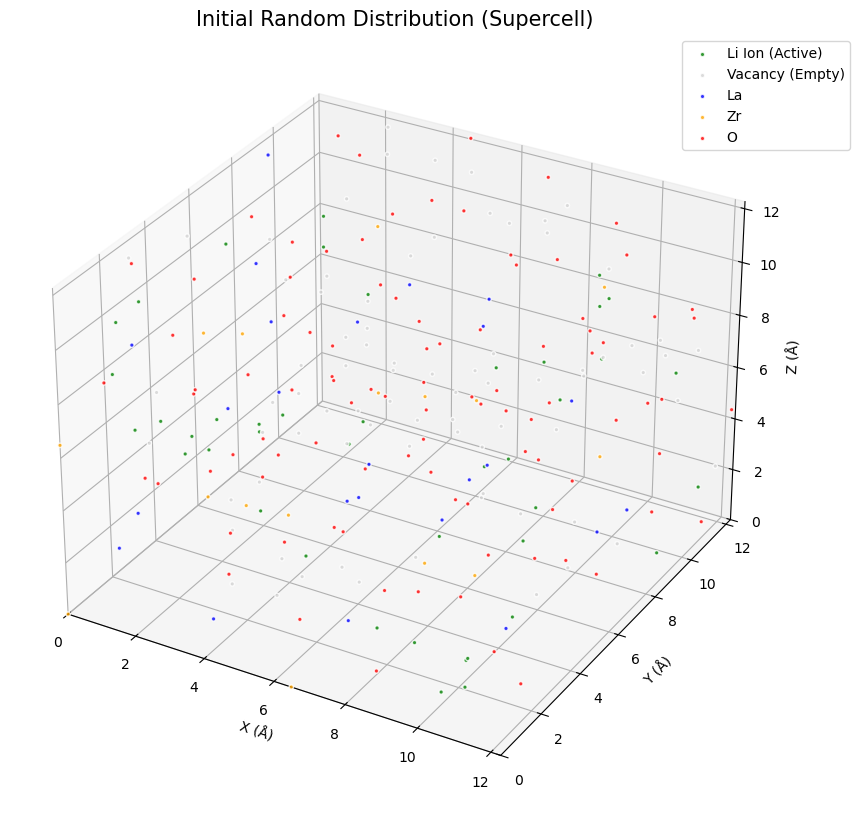

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pymatgen.core import Structure
import numpy as np

# -----------------------------------------------------------------------------
# 1. (가정) 앞서 로드된 structure와 초기화 로직이 있다고 가정합니다.
#    사용자 편의를 위해 CIF 로딩 부분부터 연결해서 작성합니다.
# -----------------------------------------------------------------------------

# 예시용 더미 CIF (LLZO 입방정 구조와 유사한 비율) 또는 사용자 제공 CIF 사용
# 실제 코드에서는 사용자가 제공한 cif_string을 그대로 쓰시면 됩니다.
# 여기서는 시각화 로직에 집중하기 위해 structure 객체가 이미 있다고 가정합니다.
# structure = Structure.from_str(cif_string, fmt="cif")
# structure.make_supercell([2, 2, 2]) 

# -----------------------------------------------------------------------------
# 2. 시각화 데이터 분류 (Data Preparation)
# -----------------------------------------------------------------------------

# 좌표 저장소 (Dictionary)
# Key: 원소 기호, Value: [x좌표 리스트, y좌표 리스트, z좌표 리스트]
vis_data = {
    'Li_Occupied': [],
    'Li_Vacancy': [],
    'La': [],
    'Zr': [],
    'O': [],
    'Other': [] # P, Ge, S 등 다른 원소가 섞일 경우 대비
}

# 색상 매핑 (Color Map)
color_map = {
    'Li_Occupied': 'green',   # 리튬: 초록색
    'Li_Vacancy': 'lightgray',# 빈자리: 연한 회색 (투명하게 처리 예정)
    'La': 'blue',             # 란타넘: 파란색
    'Zr': 'orange',           # 지르코늄: 주황색
    'O': 'red',               # 산소: 빨간색
    'Other': 'black'
}

print("3D 시각화 데이터 추출 중...")

for site in structure:
    # 카르테시안 좌표 (Cartesian Coords) 사용 -> 실제 거리 비례
    # frac_coords는 정육면체가 아닌 경우 찌그러져 보일 수 있음
    x, y, z = site.coords 
    species = site.species
    element_str = site.specie.symbol if site.is_ordered else list(site.species.keys())[0].symbol

    # 1. 리튬(Li) 처리: 확률적 배치 로직 적용
    if "Li" in [s.symbol for s in species.elements]:
        prob_li = species.get("Li", 0)
        
        # 난수 발생 (몬테카를로)
        if np.random.rand() < prob_li:
            vis_data['Li_Occupied'].append([x, y, z])
        else:
            vis_data['Li_Vacancy'].append([x, y, z])
            
    # 2. 골격(Framework) 원자 처리 (La, Zr, O)
    elif "La" in element_str:
        vis_data['La'].append([x, y, z])
    elif "Zr" in element_str:
        vis_data['Zr'].append([x, y, z])
    elif "O" in element_str:
        vis_data['O'].append([x, y, z])
    else:
        vis_data['Other'].append([x, y, z]) # LGPS의 경우 Ge, P, S 등이 여기 포함됨

# -----------------------------------------------------------------------------
# 3. 3D Plotting
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 각 원소별로 산점도 그리기
for key, coords in vis_data.items():
    if not coords: continue # 데이터 없으면 패스
    
    coords = np.array(coords) # numpy 변환
    xs, ys, zs = coords[:, 0], coords[:, 1], coords[:, 2]
    
    # 스타일 설정
    marker_size = 10
    alpha = 0.8 # 투명도
    label = key
    
    # 리튬과 빈자리는 시각적 구분을 위해 스타일 조정
    if key == 'Li_Occupied':
        marker_size = 10
        label = f"Li Ion (Active)"
    elif key == 'Li_Vacancy':
        marker_size = 10
        # alpha = 0.2 # 아주 옅게 표시 (Ghost site)
        label = f"Vacancy (Empty)"
    elif key == 'O':
        marker_size = 10 # 산소는 너무 많으므로 작게 표시
        # alpha = 0.3      # 시야 가림 방지
        
    ax.scatter(xs, ys, zs, c=color_map.get(key, 'black'), s=marker_size, alpha=alpha, label=label, edgecolors='w')

# 그래프 데코레이션
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Initial Random Distribution (Supercell)', fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# 비율 유지 (Cube Aspect Ratio)
# Matplotlib 3D는 기본적으로 축 비율을 왜곡하므로 보정 필요
try:
    # 축 범위 계산
    all_coords = np.vstack([c for c in vis_data.values() if c])
    max_range = np.array([all_coords[:,0].max()-all_coords[:,0].min(), 
                          all_coords[:,1].max()-all_coords[:,1].min(), 
                          all_coords[:,2].max()-all_coords[:,2].min()]).max() / 2.0
    mid_x = (all_coords[:,0].max()+all_coords[:,0].min()) * 0.5
    mid_y = (all_coords[:,1].max()+all_coords[:,1].min()) * 0.5
    mid_z = (all_coords[:,2].max()+all_coords[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
except:
    pass

plt.show()

In [14]:
# 먼저 라이브러리가 없다면 설치 필요 (!pip install plotly)
import plotly.graph_objects as go
import numpy as np

# -----------------------------------------------------------------------------
# (이전 단계의 vis_data 딕셔너리가 메모리에 있다고 가정합니다)
# -----------------------------------------------------------------------------

fig = go.Figure()

# Plotly는 'Trace'라는 개념으로 데이터를 추가합니다.
for key, coords in vis_data.items():
    if not coords: continue
    
    coords = np.array(coords)
    
    # 스타일 설정 (구 크기 및 투명도)
    size = 5
    opacity = 1.0
    color = color_map.get(key, 'black')
    symbol = 'circle' # 3D에서는 구처럼 보입니다
    
    s = 5
    # 원소별 커스텀 스타일
    if key == 'Li_Occupied':
        size = s
        color = 'green'
    elif key == 'Li_Vacancy':
        size = s
        opacity = 0.1  # 빈자리는 아주 흐릿하게 (Ghost)
        color = 'gray'
    elif key == 'O':
        size = s
        color = 'red'
        opacity = 1
    elif key in ['La', 'Zr']:
        size = s
        opacity = 1

    # Scatter3d 추가
    fig.add_trace(go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode='markers',
        name=key,
        marker=dict(
            size=size,
            color=color,
            opacity=opacity,
            symbol=symbol,
            line=dict(width=0) # 외곽선 제거 (더 부드럽게 보임)
        ),
        hovertemplate=f'<b>{key}</b><br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
    ))

# 레이아웃 설정 (비율 유지 및 배경 제거)
fig.update_layout(
    title="Interactive 3D Crystal Structure (Li Distribution)",
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)',
        aspectmode='data' # 실제 비율 유지 (찌그러짐 방지)
    ),
    margin=dict(r=0, b=0, l=0, t=40), # 여백 최소화
    legend=dict(x=0, y=1)
)

fig.show()

In [ ]:
import numpy as np
import random

class KMCSimulator:
    def __init__(self, structure, adj_list, initial_sites, params):
        """
        초기화 함수
        :param structure: Pymatgen Structure 객체 (좌표 정보용)
        :param adj_list: 미리 구축한 이웃 리스트 {site_idx: [neighbor_idx, ...]}
        :param initial_sites: 초기화된 사이트 정보 리스트
        :param params: 물리 상수 딕셔너리 (T, nu, Ea 등)
        """
        self.structure = structure
        self.adj_list = adj_list
        self.params = params
        
        # 1. 상태 배열 생성 (0: Vacancy, 1: Li)
        # initial_sites 딕셔너리에서 state만 뽑아서 배열로 관리 (속도 최적화)
        self.occupancy = np.array([site['state'] for site in initial_sites], dtype=int)
        
        # 2. 리튬이 있는 사이트의 인덱스만 따로 관리 (검색 속도 향상용)
        self.li_indices = set(np.where(self.occupancy == 1)[0])
        
        # 3. 시간 및 통계 변수
        self.current_time = 0.0
        self.step_count = 0
        
        # 4. 기본 호핑 속도 (Ideal Rate) 미리 계산
        # k = nu * exp(-Ea / kT)
        kb = 8.617e-5 # eV/K
        self.base_rate = params['nu'] * np.exp(-params['E_a'] / (kb * params['T']))
        print(f"🔧 엔진 초기화 완료. Base Rate: {self.base_rate:.2e} Hz")

    def get_rate(self, current_idx, neighbor_idx):
        """
        [AI가 나중에 수정할 부분]
        현재는 모든 경로가 동일한 base_rate를 가짐.
        나중에 여기에 '거리에 따른 페널티'나 '이웃 척력' 로직이 추가됨.
        """
        return self.base_rate

    def run_step(self):
        """
        BKL 알고리즘의 1회전 (1 Time Step)
        """
        # -----------------------------------------------------------
        # 1. 가능한 모든 사건(Event) 수집 (Events List)
        # -----------------------------------------------------------
        possible_events = [] # (source, target, rate) 튜플 저장
        cumulative_rates = []
        current_sum_rate = 0.0
        
        # 현재 리튬이 있는 모든 자리를 순회
        for li_idx in self.li_indices:
            # 그 리튬의 이웃들을 확인
            neighbors = self.adj_list.get(li_idx, [])
            
            for neighbor_idx in neighbors:
                # 이웃이 빈자리(Vacancy)인 경우에만 이동 가능 (Site Blocking)
                if self.occupancy[neighbor_idx] == 0:
                    
                    # 이동 확률 계산
                    rate = self.get_rate(li_idx, neighbor_idx)
                    
                    # 리스트에 추가
                    possible_events.append((li_idx, neighbor_idx))
                    current_sum_rate += rate
                    cumulative_rates.append(current_sum_rate)

        # -----------------------------------------------------------
        # 2. 룰렛 돌리기 (Selection & Time Advance)
        # -----------------------------------------------------------
        total_rate = current_sum_rate
        
        # 만약 움직일 수 있는 리튬이 하나도 없다면? (Deadlock)
        if total_rate == 0:
            print("⚠️ 움직일 수 있는 리튬이 없습니다. 시뮬레이션 종료.")
            return False

        # (A) 시간 업데이트: delta_t = -ln(u) / R_total
        u1 = np.random.rand()
        delta_t = -np.log(u1) / total_rate
        self.current_time += delta_t
        self.step_count += 1
        
        # (B) 사건 선택: 룰렛 휠 (Weighted Random)
        u2 = np.random.uniform(0, total_rate)
        
        # 이진 탐색으로 당첨된 사건 찾기 (속도 빠름)
        event_idx = np.searchsorted(cumulative_rates, u2)
        source, target = possible_events[event_idx]

        # -----------------------------------------------------------
        # 3. 실제 이동 실행 (Update State)
        # -----------------------------------------------------------
        # (1) 배열 상태 업데이트
        self.occupancy[source] = 0 # 떠난 자리는 빈자리가 됨
        self.occupancy[target] = 1 # 도착한 자리는 리튬이 됨
        
        # (2) 인덱스 세트 업데이트 (빠른 탐색을 위해)
        self.li_indices.remove(source)
        self.li_indices.add(target)
        
        return True

# =================================================================
# 실행 코드 (Usage Example)
# =================================================================

# 파라미터 설정 (Ideal Assumption)
sim_params = {
    'T': 300,        # 300 K
    'E_a': 0.3,      # 0.3 eV
    'nu': 1e13       # 10^13 Hz
}

# 시뮬레이터 생성 (이전 단계의 structure, adj_list, initial_sites 필요)
# 주의: 이 코드를 실행하려면 이전 대화의 변수들이 메모리에 있어야 합니다.
simulator = KMCSimulator(structure, adj_list, initial_sites, sim_params)

print("🚀 시뮬레이션 시작...")

# 목표 시간까지 루프 (예: 1 나노초 동안 돌리기)
target_time = 1e-9 # 1 ns
log_interval = 100 # 100 스텝마다 로그 출력

while simulator.current_time < target_time:
    success = simulator.run_step()
    
    if not success:
        break
        
    if simulator.step_count % log_interval == 0:
        print(f"[Step {simulator.step_count}] Time: {simulator.current_time*1e9:.4f} ns | Moves: 1")

print(f"🏁 종료. 총 소요 시간: {simulator.current_time*1e9:.4f} ns, 총 스텝: {simulator.step_count}")

In [15]:
# -------------------------------------------------------------------------
# [Pre-processing] 그래프 구축 (Vector 정보 포함)
# -------------------------------------------------------------------------
print("🛠️ 그래프 및 변위 벡터 구축 중...")

cutoff = 4.0
neighbors_data = structure.get_all_neighbors(r=cutoff)
adj_list = {}

for i, site in enumerate(structure):
    if "Li" not in site.species.elements[0].symbol:
        continue
        
    my_neighbors = []
    for neighbor in neighbors_data[i]:
        # neighbor.index: 이웃의 사이트 인덱스
        # neighbor.image: PBC 이미지 벡터 (예: [1, 0, 0]이면 x축 경계 넘음)
        
        target_idx = neighbor.index
        # 타겟도 리튬 자리인지 확인
        if "Li" in structure[target_idx].species.elements[0].symbol:
            
            # [핵심] 변위 벡터 계산 (Cartesian Coordinate)
            # 이웃의 좌표 - 내 좌표 (PBC 이미지 포함된 거리)
            # Pymatgen의 neighbor.coords는 이미 PBC가 고려된 실제 좌표입니다.
            # 하지만 안전하게 lattice 벡터를 이용해 직접 계산합니다.
            
            # frac_diff = 타겟_분율좌표 - 내_분율좌표 + 이미지_벡터
            frac_diff = structure[target_idx].frac_coords - site.frac_coords + neighbor.image
            
            # Cartesian 변위로 변환 (Angstrom 단위)
            cart_disp = structure.lattice.get_cartesian_coords(frac_diff)
            
            # (이웃인덱스, 변위벡터) 튜플 저장
            my_neighbors.append((target_idx, cart_disp))
            
    adj_list[i] = my_neighbors

print("✅ 그래프 구축 완료 (Vectorized Adjacency List).")

🛠️ 그래프 및 변위 벡터 구축 중...
✅ 그래프 구축 완료 (Vectorized Adjacency List).


In [16]:
import numpy as np

class KMCSimulator_Pro:
    def __init__(self, structure, adj_list, initial_sites, params):
        self.params = params
        self.adj_list = adj_list
        
        # 1. 격자 점유 상태 (0: Vacancy, 1: Li)
        self.occupancy = np.array([s['state'] for s in initial_sites], dtype=int)
        
        # 2. 리튬 이온 추적 시스템 (Particle Tracking)
        # site_idx -> particle_id 매핑 (누가 어디에 있는가)
        self.site_to_particle = {}
        # particle_id -> unwrapped_coords 매핑 (누가 어디까지 갔는가)
        self.particle_positions = {}
        
        particle_id_counter = 0
        for idx, site_info in enumerate(initial_sites):
            if site_info['state'] == 1:
                # 초기 위치(Cartesian) 저장
                # 주의: 초기에는 Unwrapped = Wrapped (0에서 시작한다고 가정해도 됨)
                start_coords = structure.lattice.get_cartesian_coords(site_info['coords'])
                
                self.site_to_particle[idx] = particle_id_counter
                self.particle_positions[particle_id_counter] = {
                    'start': np.array(start_coords), # 시작점 (MSD 기준점)
                    'current': np.array(start_coords) # 현재점 (계속 변함)
                }
                particle_id_counter += 1
                
        self.li_indices = set(self.site_to_particle.keys())
        self.num_particles = len(self.li_indices)
        
        # 3. 시간 변수
        self.current_time = 0.0
        self.step_count = 0
        
        # 4. 물리 상수 및 Base Rate 계산
        kb = 8.617e-5
        self.base_rate = params['nu'] * np.exp(-params['E_a'] / (kb * params['T']))

    def run_step(self):
        # (A) 가능한 이벤트 수집
        possible_events = [] 
        cumulative_rates = []
        current_sum = 0.0
        
        for current_site_idx in self.li_indices:
            neighbors = self.adj_list.get(current_site_idx, [])
            
            for neighbor_idx, jump_vector in neighbors:
                # 빈자리(Vacancy) 체크
                if self.occupancy[neighbor_idx] == 0:
                    rate = self.base_rate # 여기를 수정하면 복잡한 모델 가능
                    
                    # (출발지, 도착지, 변위벡터) 저장
                    possible_events.append((current_site_idx, neighbor_idx, jump_vector))
                    current_sum += rate
                    cumulative_rates.append(current_sum)
        
        total_rate = current_sum
        if total_rate == 0: return False # Deadlock

        # (B) 시간 흐름 (BKL)
        u1 = np.random.rand()
        dt = -np.log(u1) / total_rate
        self.current_time += dt
        self.step_count += 1
        
        # (C) 사건 선택 및 실행
        u2 = np.random.uniform(0, total_rate)
        event_idx = np.searchsorted(cumulative_rates, u2)
        source, target, jump_vector = possible_events[event_idx]
        
        # --- [업그레이드된 이동 로직] ---
        
        # 1. 입자 ID 식별
        p_id = self.site_to_particle.pop(source) # 출발지에서 제거
        
        # 2. Unwrapped 좌표 업데이트 (핵심!)
        # 현재 위치 += 변위 벡터 (PBC 고려됨)
        self.particle_positions[p_id]['current'] += jump_vector
        
        # 3. 격자 상태 및 매핑 업데이트
        self.occupancy[source] = 0
        self.occupancy[target] = 1
        self.site_to_particle[target] = p_id     # 도착지에 등록
        self.li_indices.remove(source)
        self.li_indices.add(target)
        
        return True

    def calculate_properties(self):
        """
        현재 시점의 MSD와 이온 전도도를 계산하여 반환
        """
        if self.current_time == 0: return 0, 0
        
        sq_displacements = []
        for p_id, pos_data in self.particle_positions.items():
            # 변위 = 현재_unwrapped - 시작점
            delta = pos_data['current'] - pos_data['start']
            sq_dist = np.sum(delta**2) # dx^2 + dy^2 + dz^2
            sq_displacements.append(sq_dist)
            
        msd = np.mean(sq_displacements) # (Angstrom^2)
        
        # 확산 계수 D = MSD / (6t) (3차원 기준)
        # D 단위: A^2 / s -> cm^2 / s 변환 필요 (1 A^2 = 1e-16 cm^2)
        D_sim = msd / (6 * self.current_time) 
        D_cm2s = D_sim * 1e-16
        
        # 전도도 Sigma (Nernst-Einstein)
        # sigma = (n * q^2 * D) / (k * T)
        # n: 농도 (개수 / cm^3)
        vol_angstrom = self.params['volume'] # Angstrom^3
        n_conc = self.num_particles / (vol_angstrom * 1e-24) # 1/cm^3
        
        q = 1.602e-19 # C
        k_J = 1.38e-23 # J/K
        
        sigma = (n_conc * (q**2) * D_cm2s) / (k_J * self.params['T']) # S/cm
        
        return msd, sigma

In [17]:
# 파라미터 준비
sim_params = {
    'T': 300,
    'E_a': 0.28, # LGPS 등 초이온전도체 수준
    'nu': 1e13,
    'volume': structure.volume # Pymatgen 구조체 부피 (A^3)
}

# 업그레이드된 시뮬레이터 생성
sim = KMCSimulator_Pro(structure, adj_list, initial_sites, sim_params)

print(f"🚀 KMC Pro 시작 (Particles: {sim.num_particles})")

# 실행 루프
target_time = 50e-9 # 50 ns (나노초 단위 시뮬레이션)
check_interval = 1000 # 1000 스텝마다 체크

while sim.current_time < target_time:
    if not sim.run_step():
        break
        
    if sim.step_count % check_interval == 0:
        msd, sigma = sim.calculate_properties()
        # 시간(ns), MSD(A^2), 전도도(mS/cm) 출력
        print(f"Time: {sim.current_time*1e9:6.2f} ns | MSD: {msd:6.2f} A^2 | Sigma: {sigma*1000:.4f} mS/cm")

# 최종 결과
msd, sigma = sim.calculate_properties()
print("="*60)
print(f"🏁 최종 결과 (T={sim_params['T']}K)")
print(f"   확산 계수 (D): {msd/(6*sim.current_time)*1e-16:.2e} cm^2/s")
print(f"   이온 전도도 (σ): {sigma:.4e} S/cm ({sigma*1000:.2f} mS/cm)")
print("="*60)

NameError: name 'initial_sites' is not defined